In [ ]:
!pip install pandas numpy matplotlib scikit-learn 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import re 


review_dataset = pd.read_csv('/kaggle/input/imdb-review-dataset/imdb_master.csv',encoding='latin-1')

In [2]:
review_dataset.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


<p>We will drop the Unnamed:0 and the file columns because we don't need them </p>

In [3]:
review_dataset = review_dataset.drop(columns=['Unnamed: 0', 'file']).reset_index(drop=True)

<h2>Null & Duplicates values check</h2>

In [4]:
for col in review_dataset.columns:
    print(f"Column: {col}, Missing values: {review_dataset[col].isnull().sum()}")

Column: type, Missing values: 0
Column: review, Missing values: 0
Column: label, Missing values: 0


In [5]:
print(review_dataset['label'].value_counts())
print()
print(review_dataset['type'].value_counts())

label
unsup    50000
neg      25000
pos      25000
Name: count, dtype: int64

type
train    75000
test     25000
Name: count, dtype: int64


<p>Because the label and type columns are categorical data that we will need so will check only the column('review') for duplicates</p>

In [6]:
review_dataset['review'].duplicated().sum().item()

1531

In [7]:
review_dataset.loc[review_dataset['review'].duplicated(),'review']

1191     What a shocker. For starters, I couldn't stand...
1406     I see that C. Thomas Howell has appeared in ma...
1407     I see that C. Thomas Howell has appeared in ma...
1841     This movie looked like it was rushed to releas...
1974     I kind of like JAG. It do have itÂ´s charm but...
                               ...                        
99736    This movie, one of the best I've ever seen, ta...
99737    It's less visceral than the only other Tsai fi...
99738    (the description of the mood of the movie may ...
99739    *MINOR SPOILERS*<br /><br />Need any further p...
99740    In the final days of the year 1999, most every...
Name: review, Length: 1531, dtype: object

<p>we will check how many times each review appears</p>

In [8]:
review_counts = review_dataset['review'].value_counts()
duplicate_reviews = review_counts[review_counts > 1]
print(f"Number of unique reviews that have duplicate: {len(duplicate_reviews)}")

Number of unique reviews that have duplicate: 1471


In [9]:
print(duplicate_reviews.value_counts())

count
2    1424
3      40
5       4
4       2
6       1
Name: count, dtype: int64


In [10]:
print('Percentage of duplicate reviews: {:.2f}%'.format((review_dataset['review'].duplicated().sum().item() / len(review_dataset)) * 100))

Percentage of duplicate reviews: 1.53%


<strong>Because it is only 1.53% we will drop those values and check again the how many test and train data we have</strong>

In [11]:
print("Label Percentage distribution:\n", review_dataset['type'].value_counts(normalize=True) * 100)

Label Percentage distribution:
 type
train    75.0
test     25.0
Name: proportion, dtype: float64


In [12]:
review_dataset = review_dataset.drop_duplicates(subset=['review'],keep='first').reset_index(drop=True)

In [13]:
print("Length of dataset after removing duplicates: ", len(review_dataset))

Length of dataset after removing duplicates:  98469


In [14]:
print("Label Percentage distribution:\n", review_dataset['type'].value_counts(normalize=True)*100)

Label Percentage distribution:
 type
train    74.813393
test     25.186607
Name: proportion, dtype: float64


<h2>Type and Label Distribution</h2>

In [15]:
type_counts = review_dataset['type'].value_counts(normalize=True)*100
label_counts = review_dataset['label'].value_counts(normalize=True)*100

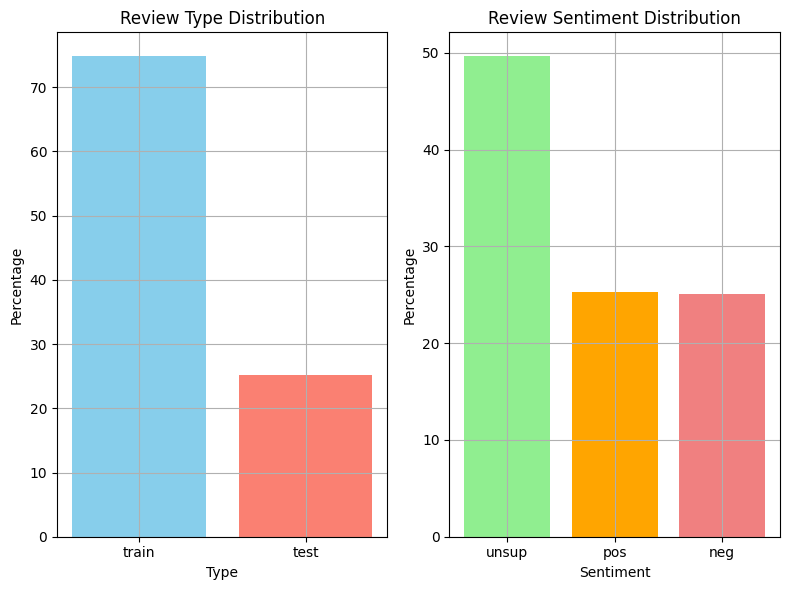

In [16]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.bar(type_counts.index,type_counts.values, color=['skyblue', 'salmon'])
plt.title('Review Type Distribution')
plt.xlabel('Type')
plt.ylabel('Percentage')
plt.grid(True)
plt.subplot(1,2,2)
plt.bar(label_counts.index,label_counts.values, color=['lightgreen', 'orange', 'lightcoral'])
plt.title('Review Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.grid(True)
plt.tight_layout()
plt.show()


<strong>Later we will split the training with the test data</strong></br>
<ul>
    <li>Training Set: ~75%</li>
    <li>Test Set: ~25%</li>
</ul>
<strong>It can be observed that a high percentage of  reviews where mostly unsupported (not positive, not negative)</strong>

<h2>Text Length Analysis</h2>

<p>we will check the length and number of words distribution</p>

In [17]:
length_of_reviews = review_dataset['review'].apply(len)
num_words_in_reviews = review_dataset['review'].apply(lambda x: len(x.split()))

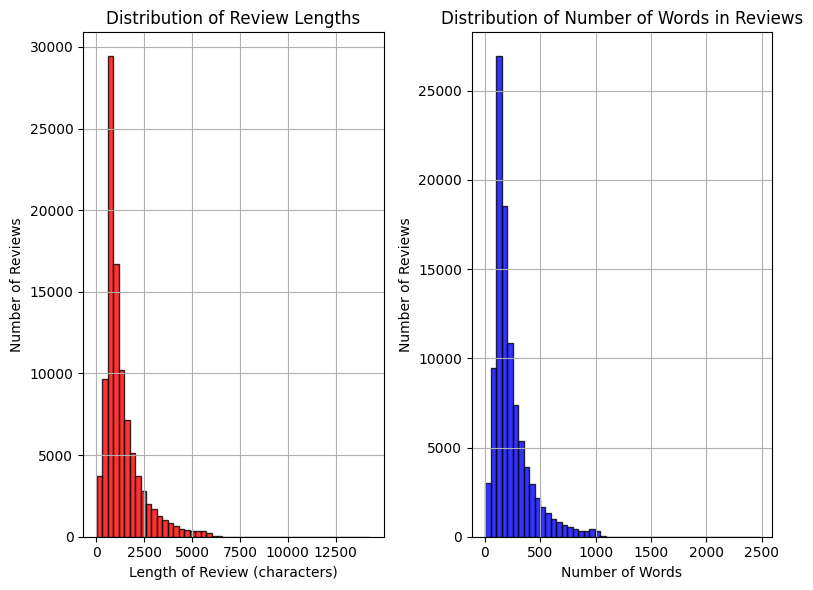

In [18]:
plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.hist(length_of_reviews,bins=50,edgecolor='black',color='red',alpha=0.8)
plt.title('Distribution of Review Lengths')
plt.xlabel('Length of Review (characters)')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.subplot(1,2,2)
plt.hist(num_words_in_reviews,bins=50,edgecolor='black',color='blue',alpha=0.8)
plt.title('Distribution of Number of Words in Reviews')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()


<p>From the plots we can see that we might have some outliers in the words or length of the reviews, but in general aspect most reviews remain consistend and friendly rage</p><br/>
<strong>So we are going to do an outlier inspection</strong>

<h2>Outlier Detection</h2>

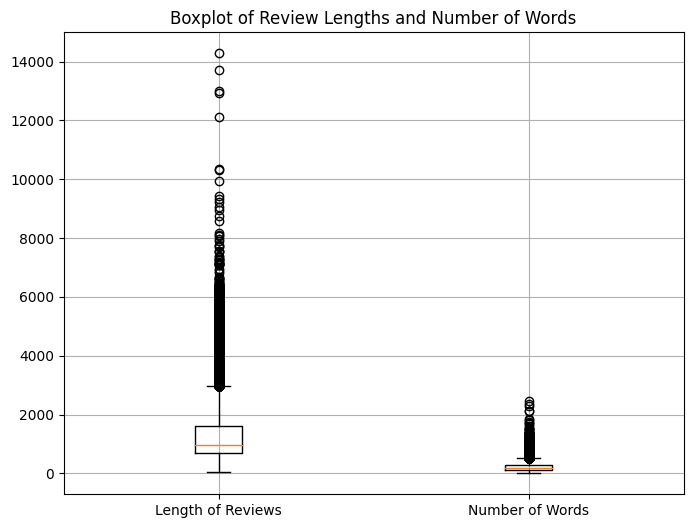

In [19]:
plt.figure(figsize=(8,6))
plt.boxplot([length_of_reviews,num_words_in_reviews],labels=['Length of Reviews','Number of Words'])
plt.title('Boxplot of Review Lengths and Number of Words')
plt.grid(True)
plt.show()


<p>so we will check the lower_bound and higher_bound of those variables:

$$lower\_bound = Q1 - 1.5 \times IQR$$

$$higher\_bound = Q3 + 1.5 \times IQR$$

In [20]:
Q1_LENGTH=  length_of_reviews.quantile(0.25)
Q3_LENGTH=  length_of_reviews.quantile(0.75)
IQR_LENGTH = Q3_LENGTH - Q1_LENGTH
lower_bound_length = Q1_LENGTH - 1.5 * IQR_LENGTH
upper_bound_length = Q3_LENGTH + 1.5 * IQR_LENGTH
print(f"Range of reviews: [{lower_bound_length if lower_bound_length >= 0 else 0},{upper_bound_length}]")
print(f"Number of outliers in review lengths: {length_of_reviews[(length_of_reviews < lower_bound_length) | (length_of_reviews > upper_bound_length)].count()}")
print("Percentage of outliers in review lengths: {:.2f}%".format((length_of_reviews[(length_of_reviews < lower_bound_length) | (length_of_reviews > upper_bound_length)].count() / len(review_dataset)) * 100))


Range of reviews: [0,2967.0]
Number of outliers in review lengths: 7303
Percentage of outliers in review lengths: 7.42%


In [21]:
Q1_WORDS = num_words_in_reviews.quantile(0.25)
Q3_WORDS = num_words_in_reviews.quantile(0.75)
IQR_WORDS = Q3_WORDS - Q1_WORDS
lower_bound_words = Q1_WORDS - 1.5 * IQR_WORDS
upper_bound_words = Q3_WORDS + 1.5 * IQR_WORDS
print(f"Range of number of words: [{lower_bound_words if lower_bound_words >= 0 else 0},{upper_bound_words}]")
print(f"Number of outliers in review words: {num_words_in_reviews[(num_words_in_reviews<lower_bound_words) | (num_words_in_reviews>upper_bound_words)].count()}")
print("Percentage of outliers in review words:: {:.2f}%".format(num_words_in_reviews[(num_words_in_reviews < lower_bound_words) | (num_words_in_reviews> upper_bound_words)].count()/ len(review_dataset) * 100))

Range of number of words: [0,517.0]
Number of outliers in review words: 7273
Percentage of outliers in review words:: 7.39%


In [22]:
print("Statistical Summary of Review Lengths:")
print(length_of_reviews.describe())
print("\nStatistical Summary of Number of Words in Reviews:")
print(num_words_in_reviews.describe())


Statistical Summary of Review Lengths:
count    98469.000000
mean      1321.695061
std        999.296689
min         32.000000
25%        702.000000
50%        978.000000
75%       1608.000000
max      14282.000000
Name: review, dtype: float64

Statistical Summary of Number of Words in Reviews:
count    98469.000000
mean       233.086352
std        172.852605
min          4.000000
25%        127.000000
50%        174.000000
75%        283.000000
max       2470.000000
Name: review, dtype: float64


<h4>Visual Distribution of outliers</h4>

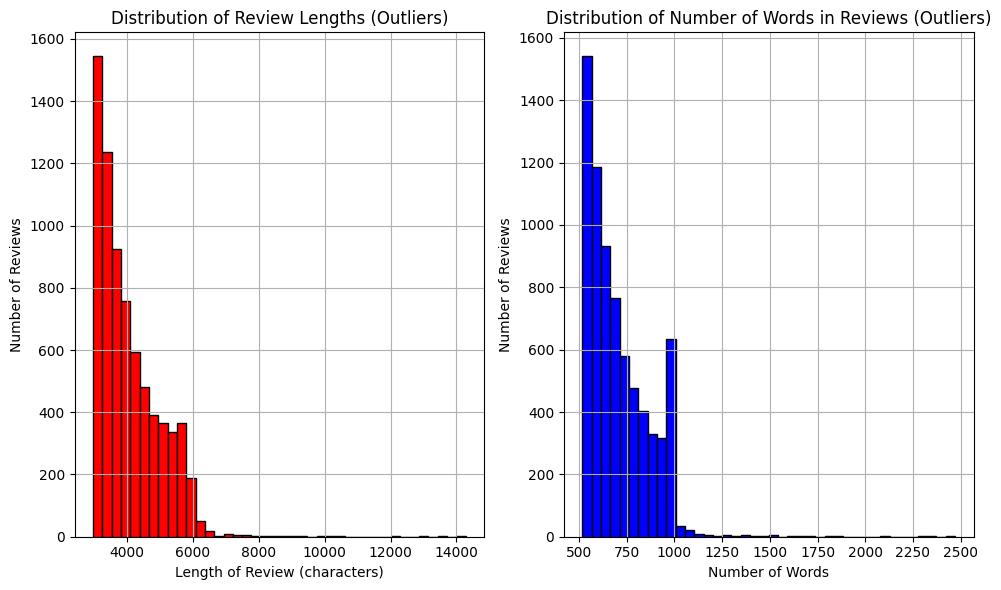

In [23]:
outliers_length = length_of_reviews[(length_of_reviews < lower_bound_length) | (length_of_reviews > upper_bound_length)]
outliers_words = num_words_in_reviews[(num_words_in_reviews<lower_bound_words) | (num_words_in_reviews>upper_bound_words)]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.hist(outliers_length,bins=40,edgecolor='black',color='red')
plt.title('Distribution of Review Lengths (Outliers)')
plt.xlabel('Length of Review (characters)')
plt.ylabel('Number of Reviews')
plt.grid(True)

plt.subplot(1,2,2)
plt.hist(outliers_words,bins=40,edgecolor='black',color='blue')
plt.title('Distribution of Number of Words in Reviews (Outliers)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.tight_layout()
plt.show()


<strong>To move to Preprocessing we should inspect the data</strong>

In [24]:
sample_length = review_dataset['review'][length_of_reviews > length_of_reviews.quantile(0.95)].sample(10).tolist()
print(sample_length)


['GLORIFYING not GLAMORIZING World War II.<br /><br />We\'ve had quite a few documentary series about World War II on the regular Television programming. Without looking up any information in some encyclopedia or film book, it seems that this old memory can recollect most names entirely on it\'s own.<br /><br />There was CRUSADE IN EUROPE,which was the title of the war memoirs of one General of the Army and later the 33rd President of the United States of America, Dwight D. Eisenhower. It told the story of the conflict in Europe as viewed by the Supreme Allied Commander.<br /><br />Then there was a CRUSADE IN THE PACIFIC(subject matter self-explanatory),which I don\'t remember much about. Newspaper Man/Author, Jim Bishop was the host/navigator of BATTLELINE.<br /><br />And there was the excellent WINSTON CHURCHILL, THE VALIANT YEARS.* The Series was a co-production of the British Broadcasting Corporation and the American Broadcasting Company. It first aired in 1960-61 season here in Th

<strong>It can be observed that the text is very big so a good solution is truncate it, BUT:</strong>
<ul>
    <li>SVM: No need it</li>
    <li>Neural Network: <strong>IS</strong> need it ,because it works in sequence of tokens</li>
</ul>
For the Analysis we will keep the length as it is 

<h2>Preprocess Data</h2>

clean data from html tags to have only the text of the user

In [25]:
import re 

def clean_and_truncate(text,max_words=300,truncate=False):
    if not isinstance(text,str):
        return ""
    text = re.sub(r'<br\s*/?>',' ',text)
    text = re.sub(r'<.*?>',' ',text)
    text = re.sub(r'\s+',' ',text).strip()

    if not truncate:
        return text
    
    words = text.split()
    if len(words) > max_words:
        words = words[:max_words]
        text=" ".join(words)

    return text
        

In [26]:
processed_sample = [clean_and_truncate(sampl) for sampl in sample_length] 
print(processed_sample[0])

GLORIFYING not GLAMORIZING World War II. We've had quite a few documentary series about World War II on the regular Television programming. Without looking up any information in some encyclopedia or film book, it seems that this old memory can recollect most names entirely on it's own. There was CRUSADE IN EUROPE,which was the title of the war memoirs of one General of the Army and later the 33rd President of the United States of America, Dwight D. Eisenhower. It told the story of the conflict in Europe as viewed by the Supreme Allied Commander. Then there was a CRUSADE IN THE PACIFIC(subject matter self-explanatory),which I don't remember much about. Newspaper Man/Author, Jim Bishop was the host/navigator of BATTLELINE. And there was the excellent WINSTON CHURCHILL, THE VALIANT YEARS.* The Series was a co-production of the British Broadcasting Corporation and the American Broadcasting Company. It first aired in 1960-61 season here in The States and boasts of having Richard Burton's sp

In [27]:
review_dataset['review'] = review_dataset['review'].apply(clean_and_truncate)

In [28]:
review_dataset.head()

,type,review,label
0,test,Once again Mr. Costner has dragged out a movie...,neg
1,test,This is an example of why the majority of acti...,neg
2,test,"First of all I hate those moronic rappers, who...",neg
3,test,Not even the Beatles could write songs everyon...,neg
4,test,Brass pictures (movies is not a fitting word f...,neg


<h2>Text Specific Analysis</h2>

### N-gram Analysis (Unigrams,Bigrams,Trigrams)

n-grams highlights context,negation,sarcasm and commmon expressions

**Helps** understand which phrases strongly discriminate between positive and negative reviews

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

def top_ngrams(corpus,n=1,top_k=20):
    vec = CountVectorizer(stop_words='english',ngram_range=(n,n)).fit(corpus)
    bag = vec.transform(corpus)
    sum_words = bag.sum(axis=0)
    words_freq = [(word,sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
    return sorted(words_freq,key=lambda x: x[1], reverse=True)[:top_k]

top_unigrams = top_ngrams(review_dataset['review'],n=1)
top_bigrams = top_ngrams(review_dataset['review'],n=2)
top_trigrams = top_ngrams(review_dataset['review'],n=3)

We incorporate the stop_words="english" so that the CountVectorizer ignore very common English words (like "this","the","end") because those words don't help the model understand meaning and only add noise to the feature matrix

In [30]:
review_dataset['label'].value_counts()

label
unsup    48887
pos      24884
neg      24698
Name: count, dtype: int64

<strong>We will focus with the reviews that we already know the labels (positive,negative)</strong>

In [31]:
pos_reviews = review_dataset[review_dataset['label']=='pos']['review']
neg_reviews = review_dataset[review_dataset['label']=='neg']['review']

top_pos_unigrams = top_ngrams(pos_reviews,n=1)
top_neg_unigrams = top_ngrams(neg_reviews,n=1)

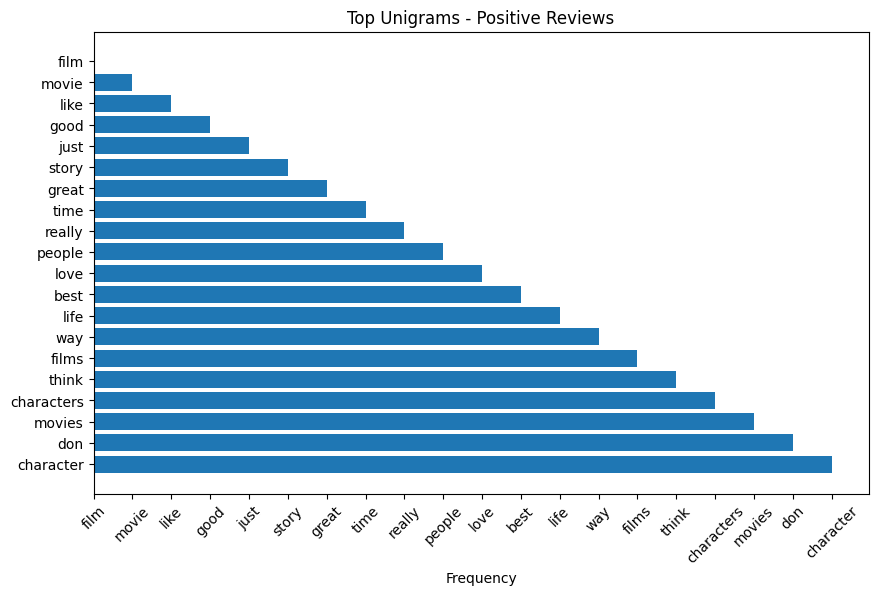

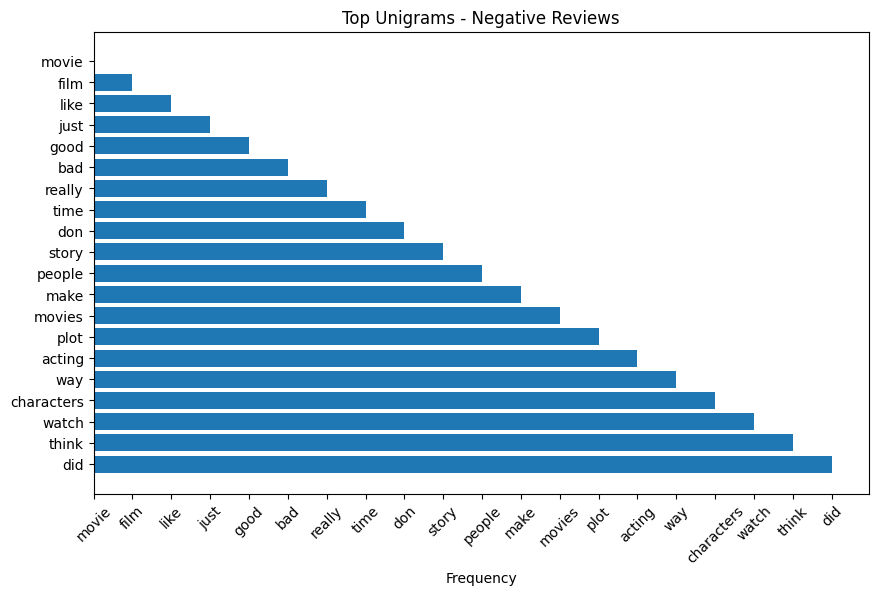

In [32]:
def plot_ngrams(ngrams,title):
    words = [w for w,_ in ngrams]
    counts = [c for c,_ in ngrams]

    plt.figure(figsize=(10,6))
    plt.barh(words,counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.xticks(rotation=45)
    plt.gca().invert_yaxis()
    plt.show()

plot_ngrams(top_pos_unigrams,"Top Unigrams - Positive Reviews")
plot_ngrams(top_neg_unigrams,"Top Unigrams - Negative Reviews")

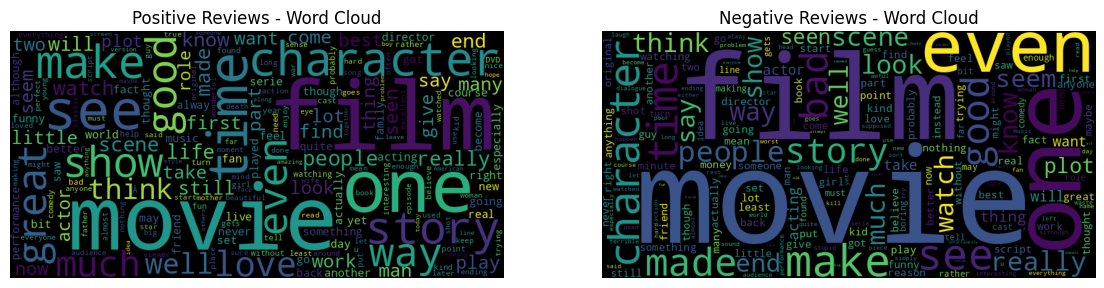

In [33]:
from wordcloud import WordCloud

pos_text = " ".join(pos_reviews)
neg_text = " ".join(neg_reviews)
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(width=800,height=400).generate(pos_text))
plt.title("Positive Reviews - Word Cloud")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(WordCloud(width=800,height=400).generate(neg_text))
plt.title("Negative Reviews - Word Cloud")
plt.axis('off')
plt.show()

### Part of Speech Analysis 
we know that sentiment is strongly expressed through **adjectives** and **adverbs**
so we are going do POS frequencies per class 

In [34]:
import spacy

nlp = spacy.load('en_core_web_sm')
def pos_counts(texts):
    tags = Counter()
    for doc in nlp.pipe(texts,batch_size=500):
        for token in doc:
            tags[token.pos_]+=1
    return tags
pos_pos= pos_counts(pos_reviews)
pos_neg = pos_counts(neg_reviews)
print("Positive POS: ",pos_pos)
print("Negative POS: ",pos_neg)

Positive POS:  Counter({'NOUN': 1085126, 'PUNCT': 810103, 'VERB': 662417, 'DET': 631314, 'ADP': 627813, 'PRON': 583708, 'ADJ': 511005, 'PROPN': 436756, 'AUX': 382717, 'ADV': 361309, 'CCONJ': 238325, 'PART': 178659, 'SCONJ': 130425, 'NUM': 65125, 'INTJ': 9407, 'SYM': 4628, 'X': 3820})
Negative POS:  Counter({'NOUN': 1058050, 'PUNCT': 811330, 'VERB': 686888, 'DET': 622948, 'PRON': 586883, 'ADP': 582588, 'ADJ': 492791, 'AUX': 414710, 'ADV': 377897, 'PROPN': 328397, 'CCONJ': 216155, 'PART': 197703, 'SCONJ': 139628, 'NUM': 64925, 'INTJ': 16885, 'X': 5802, 'SYM': 5354})


In [35]:
pos_pos_df = pd.DataFrame.from_dict(pos_pos,orient='index',columns=['count'])
pos_neg_df = pd.DataFrame.from_dict(pos_neg,orient='index',columns=['count'])
pos_pos_df['sentiment']='positive'
pos_neg_df['sentiment'] = 'negative'
sentiment_df = pd.concat([pos_pos_df,pos_neg_df]).reset_index()
sentiment_df.columns = ['pos_tag','count','sentiment']

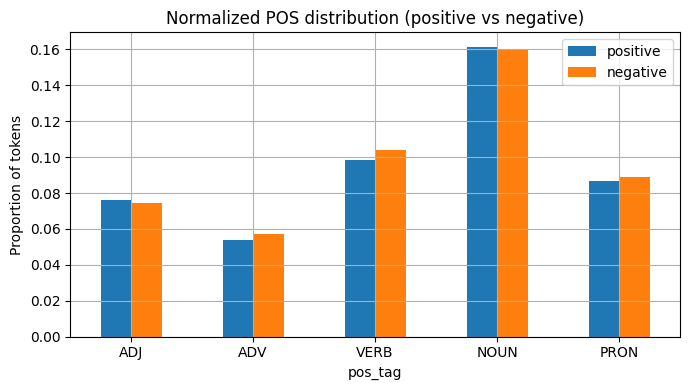

In [36]:
def pos_distribution(counter: Counter):
    total = sum(counter.values())
    return {tag:count/total for tag,count in counter.items()}

pos_pos_norm = pos_distribution(pos_pos)
pos_neg_norm = pos_distribution(pos_neg)
focus_tags = ["ADJ", "ADV", "VERB", "NOUN", "PRON"]

df = pd.DataFrame({
    "pos_tag": focus_tags,
    "positive": [pos_pos_norm.get(t,0) for t in focus_tags],
    "negative": [pos_neg_norm.get(t,0) for t in focus_tags],
})

df.set_index("pos_tag").plot(kind="bar", figsize=(7,4))
plt.ylabel("Proportion of tokens")
plt.title("Normalized POS distribution (positive vs negative)")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()

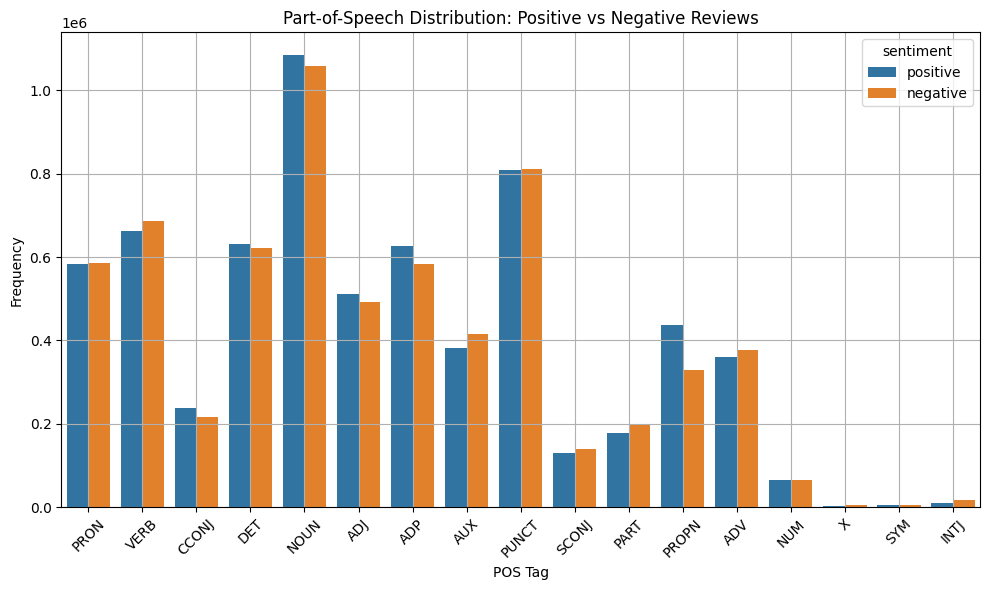

In [37]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(data=sentiment_df,x='pos_tag',y='count',hue='sentiment')
plt.title("Part-of-Speech Distribution: Positive vs Negative Reviews")
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<h3>Lexicon Analysis</h3>

In [38]:
import nltk
nltk.download("opinion_lexicon")
from nltk.corpus import opinion_lexicon

pos_lex = set(opinion_lexicon.positive())
neg_lex = set(opinion_lexicon.negative())

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!


In [39]:
def count_sentiment_words(text):
    if not isinstance(text,str):
        return 0,0
    words = text.lower().split()
    pos_count = sum(1 for w in words if w in pos_lex)
    neg_count = sum(1 for w in words if w in neg_lex)
    return pos_count,neg_count

In [41]:
mask_labeled = review_dataset['label'].isin(['pos','neg'])
labeled = review_dataset[mask_labeled].copy()

labeled['pos_count'],labeled['neg_count'] = zip(
    *labeled['review'].apply(count_sentiment_words)
)

In [42]:
labeled.groupby('label')[['pos_count','neg_count']].mean()

,pos_count,neg_count
label,,
neg,6.560126,8.312940
pos,9.362643,5.794366


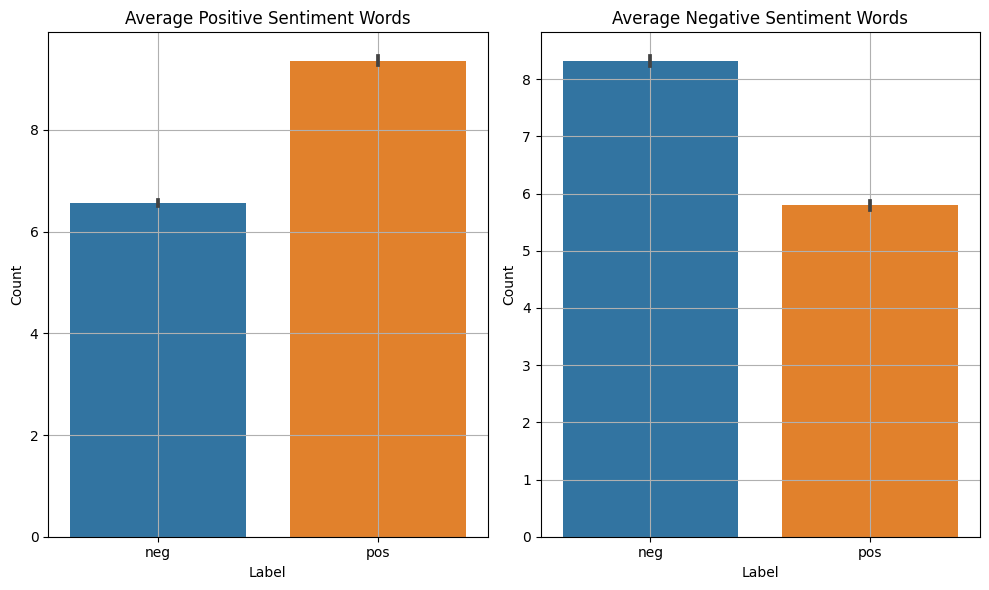

In [46]:
import seaborn as sns
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.barplot(data=labeled, x='label',y='pos_count')
plt.title('Average Positive Sentiment Words')
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True)

plt.subplot(1,2,2)
sns.barplot(data=labeled,x='label',y='neg_count')
plt.title("Average Negative Sentiment Words")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

### TF-IDF Analysis

In [51]:
labeled = review_dataset[review_dataset['label'].isin(['pos','neg'])].copy()
texts = labeled['review']
labels = labeled['label']

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    max_features=20000
)
X = tfidf.fit_transform(texts)
feature_names = tfidf.get_feature_names_out()

In [56]:
import numpy as np
pos_idx = (labels=="pos").to_numpy()
neg_idx = (labels=="neg").to_numpy()

X_pos = X[pos_idx]
X_neg = X[neg_idx]

In [57]:
pos_mean = np.asarray(X_pos.mean(axis=0)).ravel()
neg_mean = np.asarray(X_neg.mean(axis=0)).ravel()

In [58]:
df_tfidf = pd.DataFrame({
    "feature":feature_names,
    "pos_mean":pos_mean,
    "neg_mean":neg_mean
})
df_tfidf['difference'] = df_tfidf['pos_mean']-df_tfidf['neg_mean']

**Extract discriminative terms top-20 for positive & negative terms**

In [59]:
top_pos_terms = df_tfidf.sort_values("difference",ascending=False).head(20)
top_neg_terms = df_tfidf.sort_values('difference',ascending=True).head(20)

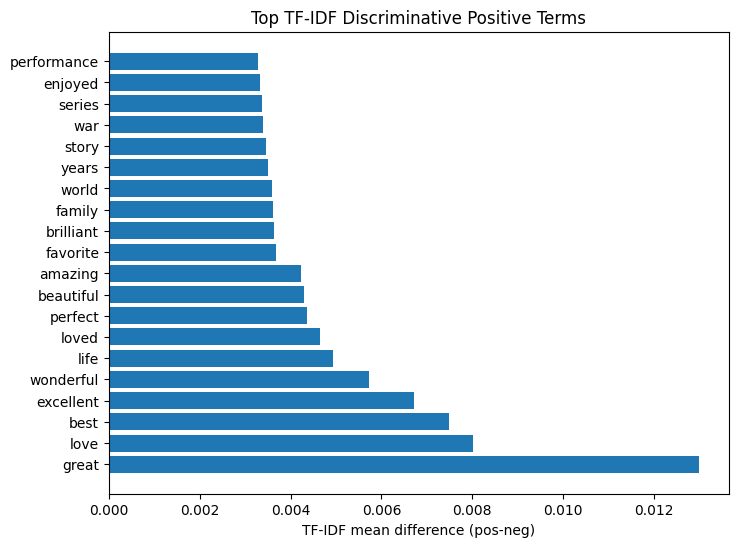

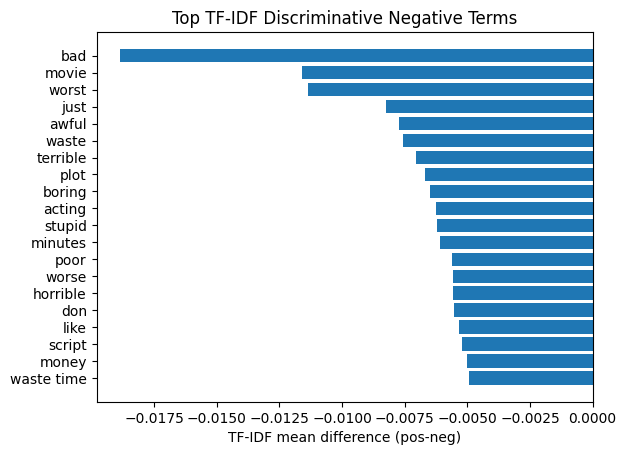

In [65]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))

plt.barh(top_pos_terms['feature'],top_pos_terms['difference'])
plt.title("Top TF-IDF Discriminative Positive Terms")
plt.xlabel("TF-IDF mean difference (pos-neg)")
plt.show()

plt.barh(top_neg_terms['feature'],top_neg_terms['difference'])
plt.title("Top TF-IDF Discriminative Negative Terms")
plt.xlabel("TF-IDF mean difference (pos-neg)")
plt.gca().invert_yaxis()
plt.show()